# Seewassertemperatur aus Satellitendaten abgeleitet

Dieses Datenset liefert tägliche Werte der Oberflächenwassertemperatur von Seen (LSWT) am Vormittag, abgeleitet aus Satellitendaten, zusammen mit zugehöriger Unsicherheit und Qualitätsstufen. Die Daten, die von den ATSR- und AVHRR-Sensoren stammen, wurden zur Konsistenzanpassung bias-korrigiert und können aufgrund fehlender Beobachtungen Lücken enthalten. LSWT ist eine essenzielle Klimavariable, die für das Verständnis der Seeökologie, hydrologischer Prozesse und großräumiger Klimawechselwirkungen von entscheidender Bedeutung ist. Die Datenentwicklung wurde durch das UK NERC GloboLakes-Projekt unterstützt, und zukünftige Verbesserungen erfolgen im Rahmen der ESA Climate Change Initiative.

**Schnellnavigation:**
* [Herunterladen und Entpacken des Datensatzes](#herunterladen-und-entpacken-des-datensatzes)
* [NetCDF4-Dateien zu einer einzigen NetCDF4-Datei zusammenführen](#netcdf4-dateien-zu-einer-einzigen-netcdf4-datei-zusammenführen)
* [Untersuchen der Metadaten der netCDF4-Datei](#untersuchen-der-metadaten-der-netcdf4-datei)
* [Exportieren der Zeitreihe im csv-Format](#exportieren-der-zeitreihe-im-csv-format)
* [Analyse und Visualisierung](#analyse-und-visualisierungsmöglichkeiten)

**Information on Dataset:**
* Quelle: <a href="https://cds.climate.copernicus.eu/datasets/satellite-lake-water-temperature?tab=overview" target="_blank">Satellite Lake Water Temperature</a>
* Author: T. Tewes (City of Konstanz)
* Notebook Version: 1.3 (Updated: January 17, 2025)

## 1. Festlegen der Pfade und Arbeitsverzeichnisse

In [1]:
import os

''' ---- Hier die Verzeichnisse angeben ---- '''
download_folder = r".\data\satellite-lake-water-temperature\download"
working_folder = r".\data\satellite-lake-water-temperature\working"
geotiff_folder = r".\data\satellite-lake-water-temperature\geotiff"
csv_folder = r".\data\satellite-lake-water-temperature\csv"
output_folder = r".\data\satellite-lake-water-temperature\output"
''' ----- Ende der Eingaben ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Herunterladen und Entpacken des Datensatzes

### 2.1 Authentifizierung

In [2]:
import cdsapi

def main():
    # API-Schlüssel für die Authentifizierung
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"

    # Erstellung des CDS-API-Clients
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Definieren Sie die "request" und laden Sie den Datensatz herunter

Definieren Sie zusätzliche Anfragefelder, um sicherzustellen, dass die Anfrage innerhalb der Dateigrößenbeschränkung bleibt. Bei der Arbeit mit Geodaten oder APIs, die Karten- oder Satellitenbilder zurückgeben, kann die Begrenzung des geografischen Interessengebiets verhindern, dass Anfragen zu groß werden und die Datei- oder Verarbeitungsgrenzen überschreiten. Begrenzungsrahmen (Bounding Boxes) werden verwendet, um das geografische Gebiet für solche Anfragen festzulegen.

Die untenstehenden Koordinaten wurden mit dem Tool <a href="https://str-ucture.github.io/bbox-extractor/" target="_blank">BBox Extractor</a> ermittelt.

*BBox Extractor ist ein webbasiertes Tool, das Benutzern hilft, interaktiv Begrenzungsrahmen-Koordinaten im WGS84-Format (Breite/Länge) auszuwählen und zu generieren. Dies ist besonders nützlich für APIs oder Datensätze, die eine Eingabe eines geografischen Gebiets erfordern*

In [3]:
# Definieren der Begrenzungsrahmen-Koordinaten (WGS84-Format) für die Region Bodensee.
# Das Koordinatenformat lautet: [Norden, Westen, Süden, Osten]
bbox_wgs84_constance = [48.0, 8.7, 47.3, 9.9]

In [4]:
# Geben Sie das Jahr von Interesse für die Datenanforderung an.
# Die entsprechende Datenversion hängt vom Jahr ab.
year = 2020

# Bestimmen Sie die Datenversion basierend auf dem Jahr:
# Version "4_5_1" wird für Jahre bis 2020 verwendet, und "4_5_2" für spätere Jahre.
if 1900 <= year <= 2100:  # Überprüfen Sie den gültigen Jahresbereich für Robustheit.
    version = "4_5_1" if year <= 2020 else "4_5_2"
else:
    raise ValueError(f"Ungültiges Jahr: {year}. Bitte geben Sie ein Jahr zwischen 1900 und 2100 an.")

In [5]:
# Definition des Datensatzes und der Request-Parameter
dataset = "satellite-lake-water-temperature"
request = {
    "variable": "all",
    "year": [f"{year}"],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "version": version,
    "area": bbox_wgs84_constance
}

In [6]:
# Führen Sie es aus, um den Datensatz herunterzuladen:
def main_retrieve():
    dataset_filename = f"{dataset}_{request['year'][0]}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)
    
    # Den Datensatz nur herunterladen, wenn er noch nicht heruntergeladen wurde
    if not os.path.isfile(dataset_filepath):
        # Rufen Sie den CDS-Client nur auf, wenn der Datensatz noch nicht heruntergeladen wurde.
        client = main()
        # Den Datensatz mit den definierten Anforderungsparametern herunterladen
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Datensatz bereits heruntergeladen.")
        
if __name__ == "__main__":
    main_retrieve()

Datensatz bereits heruntergeladen.


### 2.3 Extrahieren Sie die ZIP-Dateien in Ordner

In [7]:
import zipfile

# Construct the dataset filename and path
dataset_filename = f"{dataset}_{year}.zip"
dataset_filepath = os.path.join(download_folder, dataset_filename)
extract_folder = os.path.join(working_folder, str(year))

# Extract the zip file
try:
    os.makedirs(extract_folder, exist_ok=True)
    
    if not os.listdir(extract_folder):
        with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Successfully extracted files to: {extract_folder}")
    else:
        print("Folder is not empty. Skipping extraction.")
except FileNotFoundError:
    print(f"Error: The file {dataset_filepath} was not found.")
except zipfile.BadZipFile:
    print(f"Error: The file {dataset_filepath} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Folder is not empty. Skipping extraction.


## 3. NetCDF4-Dateien zu einer einzigen NetCDF4-Datei zusammenführen

Viele **jährliche Datensätze** werden als tägliche NetCDF4-Dateien bereitgestellt, wobei jede Datei einen Tag des Jahres repräsentiert *(365 Dateien für normale Jahre, 366 Dateien für Schaltjahre)*. Die Verwaltung dieser zahlreichen Dateien kann mühsam sein, insbesondere beim Datenzugriff oder bei der Visualisierung.

Um Arbeitsabläufe zu vereinfachen und die Effizienz der Datenverarbeitung zu verbessern, werden alle täglichen Datensätze eines bestimmten Jahres in einer **einzigen jährlichen NetCDF4-Datei** zusammengeführt. Diese Konsolidierung erleichtert die spätere Datenverarbeitung, beispielsweise für die Visualisierung oder statistische Auswertungen.

> Wichtig: Tägliche Datensätze können spärliche oder fehlende Daten enthalten. Daher kann die zusammengeführte NetCDF4-Datei, die zusammengeführte GeoTIFF-Datei oder einzelne GeoTIFF-Dateien leere Zeitpunkte enthalten.

In [8]:
import xarray as xr

# Definiere den Dateipfad für die zusammengeführte NetCDF-Datei (1 Datei pro Jahr)
nc_filepath_merged = os.path.join(output_folder,f"{dataset}_{year}.nc")

# Überprüfe, ob die zusammengeführte Datei bereits existiert
if not os.path.isfile(nc_filepath_merged):
    # Liste alle NetCDF-Dateien im Extrakt-Ordner auf
    filename_list = os.listdir(extract_folder)

    if not filename_list:
        print(f"Keine NetCDF-Dateien im Ordner {extract_folder} gefunden.")
    else:
        try:
            # Öffne und verknüpfe alle NetCDF-Dateien entlang der 'time'-Dimension
            datasets = [xr.open_dataset(os.path.join(extract_folder, f)) for f in filename_list]
            merged_dataset = xr.concat(datasets, dim='time')
            
            # Speichere den zusammengeführten Datensatz in der neuen NetCDF-Datei
            merged_dataset.to_netcdf(nc_filepath_merged)
            print(f"Neue NetCDF4-Datei erstellt unter {nc_filepath_merged} für das Jahr {year}")
        
        except Exception as e:
            print(f"Fehler bei der Dateiverarbeitung: {e}")
else:
    print(f"Zusammengeführte NetCDF-Datei für das Jahr {year} existiert bereits. Überspringe Zusammenführung.")

Zusammengeführte NetCDF-Datei für das Jahr 2020 existiert bereits. Überspringe Zusammenführung.


## 4. Untersuchen der Metadaten der netCDF4-Datei

In [9]:
import netCDF4 as nc

# Definieren Sie den Dateipfad für den zusammengeführten netCDF-Datensatz
nc_filename = f"satellite-lake-water-temperature_{year}.nc"
nc_filepath = os.path.join(output_folder, nc_filename)

# Öffnen der NetCDF-Datei im Lesemodus
nc_dataset = nc.Dataset(nc_filepath_merged, mode="r")

# Auflisten aller Variablen im Datensatz
variables_list = nc_dataset.variables.keys()
print(f"Available variables: {list(variables_list)}")

Available variables: ['lake_surface_water_temperature', 'lswt_uncertainty', 'lswt_quality_level', 'lswt_obs_instr', 'lswt_flag_bias_correction', 'lakeid_CCI', 'lakeid_GloboLakes', 'lat', 'lon', 'time']


In [10]:
import pandas as pd

# Variablennamen aus vorhandenen Variablen definieren und Variablendaten lesen
variable_name = 'lake_surface_water_temperature'
variable_data = nc_dataset[variable_name]

# Erstellen einer Zusammenfassung der Hauptvariablen
summary = {
    "Variablename": variable_name,
    "Daten Typ": variable_data.dtype,
    "Form": variable_data.shape,
    "Variableinfo": f"{variable_name}({', '.join(variable_data.dimensions)})",
    "Einheiten": getattr(variable_data, "units", "N/A"),
    "Langer Name": getattr(variable_data, "long_name", "N/A"),
}

# Anzeigen der Zusammenfassung des Datensatzes als DataFrame zur besseren Visualisierung
nc_summary = pd.DataFrame(list(summary.items()), columns=['Beschreibung', 'Bemerkungen'])

# Anzeigen des Zusammenfassungs-DataFrames
nc_summary

,Beschreibung,Bemerkungen
0,Variablename,lake_surface_water_temperature
1,Daten Typ,int16
2,Form,"(366, 14, 24)"
3,Variableinfo,"lake_surface_water_temperature(time, lat, lon)"
4,Einheiten,kelvin
5,Langer Name,lake surface skin water temperature


In [11]:
# Gib eine Zusammenfassung aller Variablen des Datensatzes aus
rows = []
for variable in variables_list:
    try:
        var_obj = nc_dataset.variables[variable]
        unit = getattr(var_obj, 'units', 'N/A')
        shape = var_obj.shape
        rows.append({
            "nc_variablen": variable,
            "einheit": unit,
            "form": shape
        })
    except Exception as e:
        print(f"Fehler bei der Verarbeitung der Variable {variable}: {e}")

# Erstelle ein DataFrame
df = pd.DataFrame(rows)
df

,nc_variablen,einheit,form
0,lake_surface_water_temperature,kelvin,"(366, 14, 24)"
1,lswt_uncertainty,kelvin,"(366, 14, 24)"
2,lswt_quality_level,N/A,"(366, 14, 24)"
3,lswt_obs_instr,N/A,"(366, 14, 24)"
4,lswt_flag_bias_correction,N/A,"(366, 14, 24)"
5,lakeid_CCI,1,"(366, 14, 24)"
6,lakeid_GloboLakes,1,"(366, 14, 24)"
7,lat,degrees_north,"(14,)"
8,lon,degrees_east,"(24,)"
9,time,seconds since 1970-01-01,"(366,)"


## 5. Exportieren der Zeitreihe im csv-Format

### 5.1 Definieren Sie eine Funktion zur Berechnung des Tagesdurchschnitts

In [12]:
import netCDF4 as nc
import pandas as pd
from datetime import datetime
import numpy as np

# Funktion zur Konvertierung von NetCDF-Daten in ein Pandas DataFrame
def netcdf_to_dataframe(nc_file):
    """
    Konvertiert eine NetCDF-Datei mit Daten zur Wassertemperatur der Seeoberfläche (LSWT)
    in ein Pandas DataFrame mit berechneten Statistiken.

    Parameter:
    nc_file (str): Pfad zur NetCDF-Datei.

    Rückgabe:
    pd.DataFrame: Ein DataFrame mit Zeit, mittlerer Temperatur, Standardabweichung, 
                  Unsicherheit, mittlerer Qualitätsstufe und Anzahl der Nicht-Null-Pixel.
    """
    # Öffne das NetCDF-Dataset im Lesemodus
    with nc.Dataset(nc_file, "r") as nc_dataset:
        # Extrahiere und dekodiere die Zeitvariable unter Berücksichtigung des Kalenders und der Einheiten
        time_var = nc_dataset.variables["time"]
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
        datetime_cftime = [t.strftime("%Y-%m-%d %H:%M:%S") for t in cftime]

        # Extrahiere Temperaturdaten und zugehörige Einheiten
        temperature_data = nc_dataset.variables["lake_surface_water_temperature"][:]
        temperature_data_units = nc_dataset.variables["lake_surface_water_temperature"].units

        # Berechne die mittlere Temperatur und die Standardabweichung für jeden Zeitschritt (gemittelt über die räumlichen Dimensionen)
        temperature_mean_list = np.nanmean(temperature_data, axis=(1, 2))
        temperature_std_list = np.nanstd(temperature_data, axis=(1, 2))
        
        # Zähle die Anzahl gültiger (nicht-NaN) Pixel für jeden Zeitschritt
        nonzero_count_list = np.count_nonzero(~np.isnan(temperature_data), axis=(1,2))

        # Extrahiere Unsicherheitsdaten und deren Einheiten
        lswt_uncertainty = nc_dataset.variables["lswt_uncertainty"][:]
        lswt_uncertainty_units = nc_dataset.variables["lswt_uncertainty"].units

        # Berechne die Unsicherheit der mittleren Temperatur mittels der Quadratwurzel der gemittelten Unsicherheitsquadrate
        lswt_uncertainty_squared = np.nanmean(lswt_uncertainty**2, axis=(1, 2))
        lswt_mean_uncertainty = np.sqrt(lswt_uncertainty_squared)
        
        # Extrahiere und berechne den mittleren Qualitätswert für jeden Zeitschritt
        lswt_quality_level = nc_dataset.variables["lswt_quality_level"][:]
        lswt_quality_level_mean_list = np.nanmean(lswt_quality_level, axis=(1, 2))

        # Erstelle ein DataFrame mit den berechneten Statistiken
        df = pd.DataFrame(
            {
                "Time": datetime_cftime,
                f"Mittlere Temperatur ({temperature_data_units[0].capitalize()})": temperature_mean_list,
                "Standardabweichung": temperature_std_list,
                f"Unsicherheit ({lswt_uncertainty_units[0].capitalize()})": lswt_mean_uncertainty,
                f"Mittlere Qualitätsstufe": lswt_quality_level_mean_list,
                "Nicht-Null-Anzahl":nonzero_count_list,
            }
        )
        return df

### 5.2 Erstellen des DataFrames für Jahresdaten und Export als CSV

In [13]:
import pandas as pd

# Definiere den CSV-Dateinamen und den Dateipfad für die Ausgabe
csv_filename = f"{dataset}_daily-mean_{year}.csv"
csv_filepath = os.path.join(csv_folder, csv_filename)

# Exportiere das DataFrame als CSV, falls es noch nicht existiert
if not os.path.isfile(csv_filepath):
    dataframe = netcdf_to_dataframe(nc_filepath_merged)
    filtered_dataframe = dataframe.dropna().reset_index(drop=True)

    filtered_dataframe.to_csv(csv_filepath, sep=",", encoding='utf8', index=False)
    print(f"Gefilterte Daten erfolgreich exportiert nach {csv_filepath}")
else:
    print(f"Datei existiert bereits unter {csv_filepath}.\nÜberspringe den Export.")
    print("Lese bestehende CSV-Datei ein...")
    filtered_dataframe = pd.read_csv(csv_filepath)

# Ändere die Pandas-Anzeigeoptionen
pd.options.display.float_format = '{:,.2f}'.format

# Zeige das DataFrame an
filtered_dataframe.head()

Datei existiert bereits unter .\data\satellite-lake-water-temperature\csv\satellite-lake-water-temperature_daily-mean_2020.csv.
Überspringe den Export.
Lese bestehende CSV-Datei ein...


,Time,Mittlere Temperatur (K),Standardabweichung,Unsicherheit (K),Mittlere Qualitätsstufe,Nicht-Null-Anzahl
0,2020-01-01 12:00:00,278.33,0.95,0.23,3.89,9.00
1,2020-01-03 12:00:00,272.20,0.00,0.26,1.00,1.00
2,2020-01-05 12:00:00,278.80,0.76,0.24,4.17,46.00
3,2020-01-06 12:00:00,278.11,0.16,0.20,2.00,3.00
4,2020-01-07 12:00:00,274.36,1.44,0.28,1.62,8.00


## 6. Analyse und Visualisierung

### 6.1 Visualisierung des Tagesdurchschnitts mit Liniendiagramm

> Hinweis: Aufgrund der begrenzten täglichen/monatlichen Daten für den Datensatz 2023 funktionieren **Plots** nicht richtig.


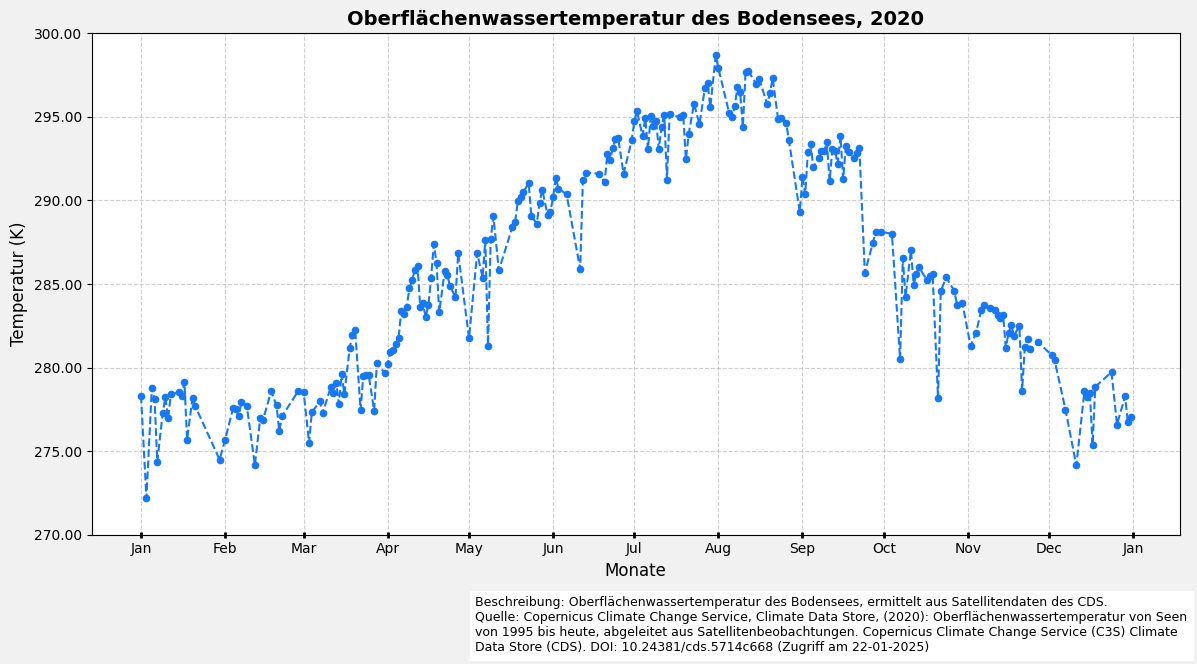

In [14]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator 
import matplotlib.ticker as ticker
import math

# Bereite das DataFrame für die Darstellung vor
filtered_df = filtered_dataframe.copy()

# Konvertiere 'Time' in das Datetime-Format und extrahiere sowie formatiere die 'Date'-Spalte
filtered_df['Time'] = pd.to_datetime(filtered_df['Time'])
filtered_df['Date'] = filtered_df['Time'].dt.date

# Bestimme den Wertebereich für die y-Achse, gerundet auf die nächste Zehnerstelle
vmax = math.ceil(filtered_df['Mittlere Temperatur (K)'].max() / 10) * 10
vmin = math.floor(filtered_df['Mittlere Temperatur (K)'].min() / 10) * 10

# Erstelle die Figur und Achsen
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

# Plotten die mittlere Temperatur
ax.plot(filtered_df['Date'],
        filtered_df['Mittlere Temperatur (K)'],
        marker='o',
        markersize=4.5,
        linestyle='--',
        color='#1877F2',
        label="Oberflächenwassertemperatur",
        )

# Formatieren der x-Achse für bessere Lesbarkeit
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b'))
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2)
ax.tick_params(axis='x', which='minor', length=3, direction='inout')

# Setzen der y-Achsen-Grenzen
ax.set_ylim(vmin, vmax)

# Setzen der Achsenbeschriftungen und Titel des Diagramms
ax.set_xlabel('Monate', fontsize=12)
ax.set_ylabel('Temperatur (K)', fontsize=12)
ax.set_title(f'Oberflächenwassertemperatur des Bodensees, {year}', fontsize=14, fontweight='bold')

# Hinzufügen eines Rasters zum Diagramm und Formatierung der y-Achse
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Hinzufügen einer Beschreibung und Quelleninformation
plt.figtext(
    0.4,
    -0.05,
    (
        'Beschreibung: Oberflächenwassertemperatur des Bodensees, ermittelt aus Satellitendaten des CDS.\n'
        'Quelle: Copernicus Climate Change Service, Climate Data Store, (2020): Oberflächenwassertemperatur von Seen '
        'von 1995 bis heute, abgeleitet aus Satellitenbeobachtungen. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). '
        'DOI: 10.24381/cds.5714c668 (Zugriff am 22-01-2025)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

# Layout anpassen und das Diagramm anzeigen
plt.tight_layout()
plt.show()


### 6.2 Visualisierung des monatlichen Durchschnitts mit Liniendiagramm

In [15]:
# Bereite das DataFrame für die Darstellung vor, indem monatliche Aggregation und Fehlerfortpflanzung durchgeführt werden

# Gruppiere nach monatlichen Perioden anhand der 'Date'-Spalte
filtered_df_monthly = (
    filtered_df.groupby(pd.PeriodIndex(filtered_df["Date"], freq="M"))[[  
        "Mittlere Temperatur (K)",  
        "Standardabweichung",  
        "Unsicherheit (K)",  
        "Mittlere Qualitätsstufe"  
    ]]  
    .agg({  
        "Mittlere Temperatur (K)": "mean",  
        "Standardabweichung": lambda x: (x**2).mean()**0.5,  
        "Unsicherheit (K)": lambda x: (x**2).mean()**0.5,  
        "Mittlere Qualitätsstufe": "mean"  
    })  
    .reset_index()  
)

# Konvertiere den PeriodIndex zurück in Zeitstempel für eine konsistente Datumsverarbeitung
filtered_df_monthly['Date'] = filtered_df_monthly['Date'].dt.to_timestamp()

# Zeige das DataFrame an
filtered_df_monthly.head()


,Date,Mittlere Temperatur (K),Standardabweichung,Unsicherheit (K),Mittlere Qualitätsstufe
0,2020-01-01,277.17,1.12,0.23,3.21
1,2020-02-01,277.13,1.00,0.29,3.79
2,2020-03-01,278.94,1.06,0.26,3.72
3,2020-04-01,284.05,1.53,0.26,3.82
4,2020-05-01,288.05,1.15,0.48,3.85


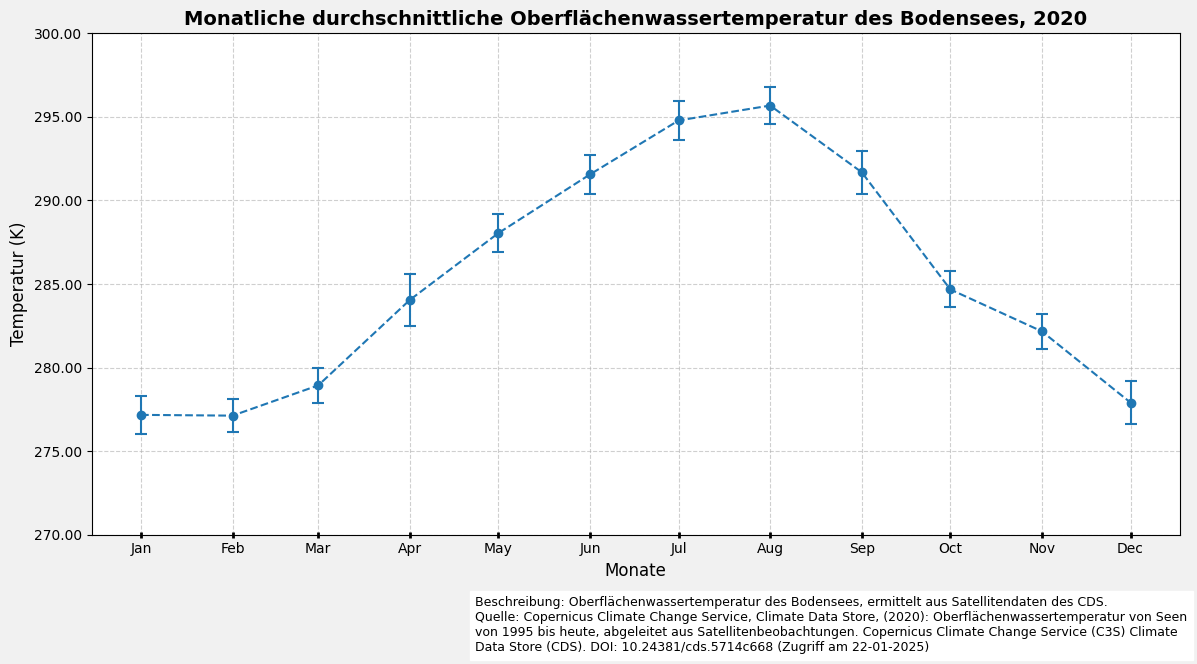

In [16]:
# Erstelle die Grafik und Achsen
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

# Plotte die monatliche mittlere Temperatur mit Fehlerbalken
ax.errorbar(
    filtered_df_monthly['Date'],
    filtered_df_monthly['Mittlere Temperatur (K)'],
    yerr=filtered_df_monthly['Standardabweichung'],
    fmt='o--',
    label='Mittlere Temperatur ± Unsicherheit',
    capsize=4,
    elinewidth=1.5,
    capthick=1.5,
)

# Formatieren der x-Achse für bessere Lesbarkeit
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b'))
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2)
ax.tick_params(axis='x', which='minor', length=3, direction='inout')

# Setzen der y-Achsen-Grenzen
ax.set_ylim(vmin, vmax)

# Setzen der Achsenbeschriftungen und Titel des Diagramms
ax.set_xlabel('Monate', fontsize=12)
ax.set_ylabel('Temperatur (K)', fontsize=12)
ax.set_title(f'Monatliche durchschnittliche Oberflächenwassertemperatur des Bodensees, {year}', fontsize=14, fontweight='bold')

# Hinzufügen eines Rasters zum Diagramm und Formatierung der y-Achse
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Hinzufügen einer Beschreibung und Quelleninformation
plt.figtext(
    0.4,
    -0.05,
    (
        'Beschreibung: Oberflächenwassertemperatur des Bodensees, ermittelt aus Satellitendaten des CDS.\n'
        'Quelle: Copernicus Climate Change Service, Climate Data Store, (2020): Oberflächenwassertemperatur von Seen '
        'von 1995 bis heute, abgeleitet aus Satellitenbeobachtungen. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). '
        'DOI: 10.24381/cds.5714c668 (Zugriff am 22-01-2025)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

# Layout anpassen und das Diagramm anzeigen
plt.tight_layout()
plt.show()


### 6.3 Visualisierung des monatlichen Durchschnitts mit Balkendiagramm

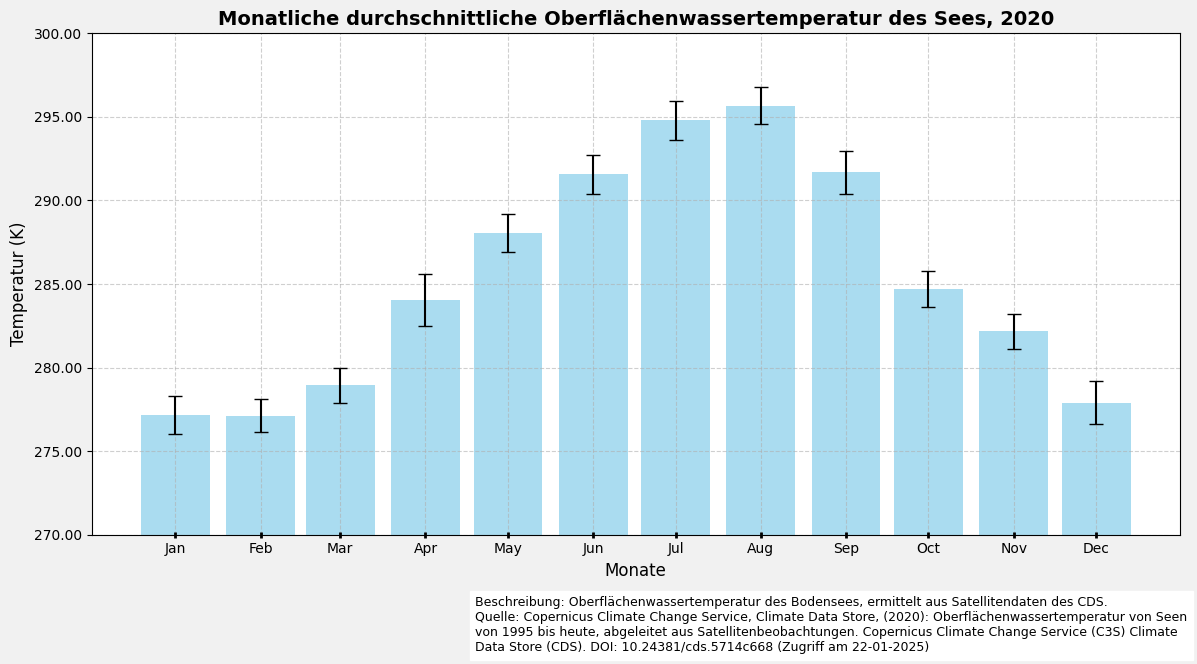

In [17]:
# Erstellen die Figur und Achsen
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

# Plotten die monatliche mittlere Temperatur als Balkendiagramm
ax.bar(
    filtered_df_monthly['Date'],
    filtered_df_monthly['Mittlere Temperatur (K)'],
    yerr=filtered_df_monthly['Standardabweichung'],
    color='skyblue',
    alpha=0.7,
    width=25,
    label='Mittlere Temperatur ± Unsicherheit',
    capsize=5,
    error_kw=dict(ecolor='black', lw=1.5),
)

# Formatieren der x-Achse für bessere Lesbarkeit
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b'))
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2)
ax.tick_params(axis='x', which='minor', length=3, direction='inout')

# Setzen die Grenzen der y-Achse
ax.set_ylim(vmin, vmax)

# Setzen der Achsenbeschriftungen und Titel des Diagramms
ax.set_xlabel('Monate', fontsize=12)
ax.set_ylabel('Temperatur (K)', fontsize=12)
ax.set_title(f'Monatliche durchschnittliche Oberflächenwassertemperatur des Sees, {year}', fontsize=14, fontweight='bold')

# Hinzufügen eines Rasters zum Diagramm und Formatierung der y-Achse
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Hinzufügen einer Beschreibung und Quelleninformation
plt.figtext(
    0.4,
    -0.05,
    (
        'Beschreibung: Oberflächenwassertemperatur des Bodensees, ermittelt aus Satellitendaten des CDS.\n'
        'Quelle: Copernicus Climate Change Service, Climate Data Store, (2020): Oberflächenwassertemperatur von Seen '
        'von 1995 bis heute, abgeleitet aus Satellitenbeobachtungen. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). '
        'DOI: 10.24381/cds.5714c668 (Zugriff am 22-01-2025)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

# Layout anpassen und das Diagramm anzeigen
plt.tight_layout()
plt.show()


## 7. Export des NetCDF4-Datei nach GeoTIFF

### 7.1 Exportieren Sie den jährlichen Datensatz als eine GeoTIFF-Datei

In [18]:
import rasterio  
from rasterio.transform import from_origin  
import netCDF4 as nc  
from tqdm.notebook import tqdm  

def main_export_geotiff(nc_file):  
    # NetCDF-Datei öffnen und Variable auslesen  
    nc_dataset = nc.Dataset(nc_file, mode='r')  
    temperature_data = nc_dataset[variable_name]  

    # Zeitvariable extrahieren und in ein lesbares Datumsformat konvertieren  
    time_var = nc_dataset.variables['time']  
    time_units = nc_dataset.variables['time'].units  
    time_calendar = getattr(time_var, "calendar", "standard")  
    cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)  

    # Räumliche Auflösung berechnen und Rastertransformation definieren  
    lat = nc_dataset['lat'][:]  
    lon = nc_dataset['lon'][:]  

    pixelgröße_lat = (lat.max() - lat.min()) / (len(lat) - 1)  
    pixelgröße_lon = (lon.max() - lon.min()) / (len(lon) - 1)  
    transform = from_origin(lon.min() - pixelgröße_lon / 2,  
                            lat.min() - pixelgröße_lat / 2,  
                            pixelgröße_lon,  
                            -pixelgröße_lat  
                            )  

    # Ausgabepfad für das zusammengeführte GeoTIFF definieren  
    output_filename = f"{variable_name}_{year}_merged.tif"  
    output_folder = os.path.join(geotiff_folder, "merged_geotiff")  
    os.makedirs(output_folder, exist_ok=True)  
    output_filepath = os.path.join(output_folder, output_filename)  

    if not os.path.isfile(output_filepath):  
        # GeoTIFF-Datei mit mehreren Bändern (je eines pro Zeitschritt) erstellen  
        with rasterio.open(  
            output_filepath,  
            "w",  
            driver="GTiff",  
            dtype=str(temperature_data.dtype),  
            width=temperature_data.shape[2],  
            height=temperature_data.shape[1],  
            count=temperature_data.shape[0],  
            crs="EPSG:4326",  
            nodata=-9999,  
            transform=transform,        
        ) as dst:  
            # Jeden Zeitschritt als separates Band schreiben  
            for day_index in tqdm(range(temperature_data.shape[0]),  
                                  desc=f"Zusammengeführte GeoTIFF-Datei für {year} exportieren"):  
                band_data = temperature_data[day_index, :, :]  
                dt = cftime[day_index]  
                band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"  

                # Daten für das aktuelle Band schreiben und Band annotieren  
                dst.write(band_data, day_index + 1)  
                dst.set_band_description(day_index + 1, band_desc)  
    else:  
        print(f"'{output_filename}' existiert bereits. Export überspringen.")  

# Parameter für die Verarbeitung der NetCDF-Datei definieren  
nc_filename = f"{dataset}_{year}.nc"  
nc_filepath_merged = os.path.join(output_folder, nc_filename)  
variable_name = 'lake_surface_water_temperature'  

# Exportprozess ausführen  
main_export_geotiff(nc_filepath_merged)

'lake_surface_water_temperature_2020_merged.tif' existiert bereits. Export überspringen.


## 7.2 Export des Jahresdatensatzes als einzelne GeoTIFF-Dateien  

In [19]:
import rasterio  
from rasterio.transform import from_origin  
import netCDF4 as nc  
from tqdm.notebook import tqdm  

def main_export_individual_geotiff(nc_file):  
    # NetCDF-Datensatz öffnen und Variablendaten auslesen  
    nc_dataset = nc.Dataset(nc_file, mode='r')  
    temperature_data = nc_dataset[variable_name]  

    # Zeitvariable extrahieren und in ein lesbares Datumsformat konvertieren  
    time_var = nc_dataset.variables['time']  
    time_units = nc_dataset.variables['time'].units  
    time_calendar = getattr(time_var, "calendar", "standard")  
    cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)  

    # Räumliche Auflösung berechnen und Rastertransformation definieren  
    lat = nc_dataset['lat'][:]  
    lon = nc_dataset['lon'][:]  

    pixelgröße_lat = (lat.max() - lat.min()) / (len(lat) - 1)  
    pixelgröße_lon = (lon.max() - lon.min()) / (len(lon) - 1)  
    transform = from_origin(lon.min() - pixelgröße_lon / 2,  
                            lat.min() - pixelgröße_lat / 2,  
                            pixelgröße_lon,  
                            -pixelgröße_lat  
                            )  

    # Ausgabeordner für einzelne GeoTIFF-Dateien des ausgewählten Jahres definieren und erstellen  
    year_folder = os.path.join(geotiff_folder, f"{year}_individual_geotiff")  
    os.makedirs(year_folder, exist_ok=True)  

    if len(os.listdir(year_folder)) == 0:  
        # Einzelne GeoTIFF-Dateien mit täglichen Zeitschritten erstellen  
        for day_index in tqdm(range(temperature_data.shape[0]), desc=f"GeoTIFF-Dateien für {year} exportieren"):  
            dt = cftime[day_index]  
            band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"  

            output_filename = f"{variable_name}_{band_desc}.tif"  
            output_filepath = os.path.join(year_folder, output_filename)  

            band_data = temperature_data[day_index, :, :]  

            # GeoTIFF-Datei mit einem einzelnen Band für jeden Zeitschritt erstellen  
            with rasterio.open(  
                output_filepath,  
                "w",  
                driver="GTiff",  
                dtype=str(band_data.dtype),  
                width=band_data.shape[1],  
                height=band_data.shape[0],  
                count=1,  
                crs="EPSG:4326",  
                nodata=-9999,  
                transform=transform,        
            ) as dst:  
                # Daten für das aktuelle Band schreiben und Band annotieren  
                dst.write(band_data, 1)  
                dst.set_band_description(1, band_desc)  
    else:  
        print(f"Ordner ist nicht leer. Export überspringen.")  

# Parameter für die Verarbeitung der NetCDF-Datei definieren  
nc_filename_merged = f"{dataset}_{year}.nc"  
nc_filepath_merged = os.path.join(output_folder, nc_filename)  
variable_name = 'lake_surface_water_temperature'  

# Exportprozess ausführen  
main_export_individual_geotiff(nc_filepath_merged)  


Ordner ist nicht leer. Export überspringen.


## 8. Alle verfügbaren Daten von 1995 bis 2023 visualisieren

In [20]:
import re  
import pandas as pd  

# Funktion definieren, um Metadaten aus einem NetCDF-Dateinamen zu extrahieren  
def meta(filename):  
    match = re.search(r"(.+?)_(\d{4})\.nc", filename)  
    if not match:  
        raise ValueError("Der angegebene Dateiname entspricht nicht dem erwarteten Namensschema.")  

    def get_nc_variable():  
        with nc.Dataset(os.path.join(output_folder, filename), 'r') as nc_dataset:  
            nc_variable_name_list = nc_dataset.variables.keys()  

            primary_variable_index = 0  
            primary_variable = [*nc_variable_name_list][primary_variable_index]  
            primary_variable_shape = np.shape(nc_dataset[primary_variable])  

            return primary_variable, primary_variable_shape  

    # Metadaten als Dictionary zurückgeben  
    return dict(  
        filename=filename,  
        path=os.path.join(output_folder, filename),  
        year=match.group(2),  
        variable_name=get_nc_variable()[0],  
        variable_shape=get_nc_variable()[1],  
    )  

# Alle NetCDF-Dateien im Ausgabeordner auflisten, verarbeiten und nach Jahr sortieren  
nc_files = [meta(f) for f in os.listdir(output_folder) if f.endswith('.nc')]  
nc_files = sorted(nc_files, key=lambda x: x['year'])  

df_nc_files = pd.DataFrame.from_dict(nc_files)  

# DataFrame anzeigen, ohne den Pfad anzuzeigen  
df_nc_files.head().loc[:, df_nc_files.columns != 'path']

,filename,year,variable_name,variable_shape
0,satellite-lake-water-temperature_1995.nc,1995,lake_surface_water_temperature,"(201, 14, 24)"
1,satellite-lake-water-temperature_1996.nc,1996,lake_surface_water_temperature,"(180, 14, 24)"
2,satellite-lake-water-temperature_1997.nc,1997,lake_surface_water_temperature,"(361, 14, 24)"
3,satellite-lake-water-temperature_1998.nc,1998,lake_surface_water_temperature,"(360, 14, 24)"
4,satellite-lake-water-temperature_1999.nc,1999,lake_surface_water_temperature,"(352, 14, 24)"


Keine NetCDF-Datei für das angegebene Jahr gefunden.
Das neueste verfügbare Jahr wird ausgewählt.
Es werden Daten aus dem Jahr 2020 verwendet.


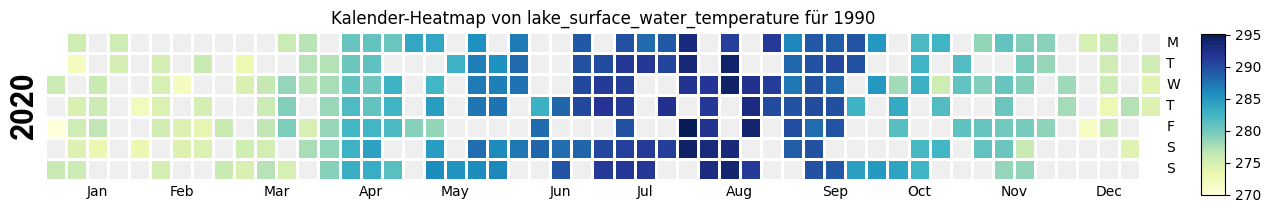

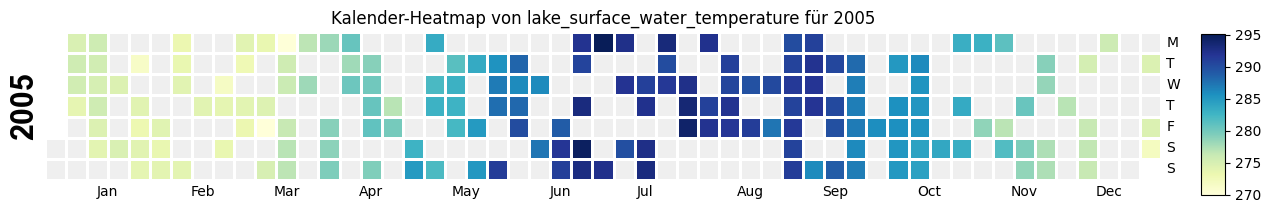

In [21]:
import xarray as xr  
import calmap  
import matplotlib.pyplot as plt  
import pandas as pd  
import math as ma  

def plot_calendarplot(year=None):  
    # NetCDF-Datei für das angegebene Jahr filtern  
    nc_file = next((item for item in nc_files if item['year'] == str(year)), None)  

    if not nc_file:  
        print(f"Keine NetCDF-Datei für das angegebene Jahr gefunden.")  
        print("Das neueste verfügbare Jahr wird ausgewählt.")  
        if nc_files:  
            nc_file = nc_files[-1]  # Das neueste verfügbare Jahr auswählen  
            print(f"Es werden Daten aus dem Jahr {nc_file['year']} verwendet.")  
        else:  
            print("Keine NetCDF-Dateien verfügbar.")  
            return  

    # Die NetCDF-Datei öffnen und die angegebene Variable verarbeiten  
    with xr.open_dataset(nc_file['path']) as nc_dataset:  
        # Variablendaten als DataFrame extrahieren  
        variable_data = nc_dataset[nc_file['variable_name']]  
        df = variable_data.to_dataframe().reset_index().dropna().reset_index(drop=True)  

        # 'time' in das Datetime-Format konvertieren und 'day_of_year' sowie 'date' ableiten  
        df['time'] = pd.to_datetime(df['time'])  
        df['day_of_year'] = df['time'].dt.dayofyear  
        df['date'] = df['time'].dt.year.astype(str) + '-' + df['day_of_year'].astype(str).str.zfill(3)  
        df['date'] = pd.to_datetime(df['date'], format='%Y-%j').dt.strftime('%Y-%m-%d')  

        # Nach 'date' gruppieren und den täglichen Mittelwert für die Variable berechnen  
        df2 = df.groupby('date')[variable_name].mean()  

    # Sicherstellen, dass der Index des Ergebnisses ein datetime-Format hat  
    df2.index = pd.to_datetime(df2.index)  

    # Kalender-Heatmap der mittleren Temperaturwerte plotten  
    fig, axs = calmap.calendarplot(df2,  
                                fig_kws={'figsize': (12, 8)},  
                                yearlabel_kws={'color': 'black', 'fontsize': 22},  
                                subplot_kws={'title': f'Kalender-Heatmap von {variable_name} für {year}'},  
                                cmap='YlGnBu',  
                                fillcolor='#efefef',  
                                daylabels='MTWTFSS',  
                                linecolor='#ffffff',  
                                dayticks=True,  
                                )  

    # Farbleiste rechts neben dem Diagramm hinzufügen  
    cax = fig.add_axes([1.005, 0.38, 0.02, 0.2])  
    vmin = ma.floor(df2.min() // 5 * 5)  
    vmax = ma.ceil(df2.max() // 5 * 5)  

    sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))  
    cbar = fig.colorbar(sm, cax=cax)  

    # Ticks auf der Farbleiste anpassen  
    tick_interval = 5  
    ticks = np.arange(vmin, vmax + 1, tick_interval)  
    cbar.set_ticks(ticks)  # Ticks setzen  
    cbar.set_ticklabels(ticks)  

if __name__ == "__main__":  
    # Kalender-Heatmap für das angegebene Jahr plotten  
    plot_calendarplot(year=1990)  
    plot_calendarplot(year=2005)  
